In [34]:
# Une structure classique pour lire un fichier stocké sur le Minio sur datalab

### La bibliothèqe os permet d'interagir avec le système d'exploitation. Ici, elle est utilisée pour accéder aux variables d'environnement.
### La bibliothèque polars est une bibliothèque puissante pour manipuler des données de manière efficace. Elle est utilisée ici pour lire le fichier Parquet.
import os
import polars as pl


storage_options = {
    "aws_endpoint":  'https://'+'minio-simple.lab.groupe-genes.fr', # L'adresse de l'endpoint S3 du datalab du Genes.
    "aws_access_key_id": os.environ["AWS_ACCESS_KEY_ID"], 
    "aws_secret_access_key": os.environ["AWS_SECRET_ACCESS_KEY"],
    "aws_region": os.environ["AWS_DEFAULT_REGION"],
    "aws_token": os.environ["AWS_SESSION_TOKEN"] # aws_access_key_id, aws_secret_access_key, aws_region, aws_token sont les clés d'accès vous authentifier auprès du service de stockage.
  }
username = os.environ["VAULT_TOP_DIR"] # un peu bancal pour avoir le username. Cette ligne récupère le nom d'utilisateur à partir d'une variable d'environnement. Cependant, utiliser VAULT_TOP_DIR pour stocker un nom d'utilisateur n'est pas une pratique courante et pourrait être source d'erreurs. 
                                       # Il est préférable d'utiliser une variable d'environnement dédiée au nom d'utilisateur.

df = pl.read_parquet(source=f"s3://{username}/diffusion/INSEE/prenoms-nat2022.parquet", 
                     storage_options=storage_options) # Lit le fichier parquet à l'endroit où nous l'avons stocké avec une fonction de la bibliothèque polars
print(df)





shape: (703_007, 4)
┌──────┬────────────────┬────────┬────────┐
│ sexe ┆ preusuel       ┆ annais ┆ nombre │
│ ---  ┆ ---            ┆ ---    ┆ ---    │
│ i64  ┆ str            ┆ str    ┆ i64    │
╞══════╪════════════════╪════════╪════════╡
│ 1    ┆ _PRENOMS_RARES ┆ 1900   ┆ 1249   │
│ 1    ┆ _PRENOMS_RARES ┆ 1901   ┆ 1342   │
│ 1    ┆ _PRENOMS_RARES ┆ 1902   ┆ 1330   │
│ 1    ┆ _PRENOMS_RARES ┆ 1903   ┆ 1286   │
│ 1    ┆ _PRENOMS_RARES ┆ 1904   ┆ 1430   │
│ …    ┆ …              ┆ …      ┆ …      │
│ 2    ┆ ZYNEB          ┆ 2019   ┆ 7      │
│ 2    ┆ ZYNEB          ┆ 2020   ┆ 8      │
│ 2    ┆ ZYNEB          ┆ 2021   ┆ 6      │
│ 2    ┆ ZYNEB          ┆ 2022   ┆ 4      │
│ 2    ┆ ZYNEB          ┆ XXXX   ┆ 19     │
└──────┴────────────────┴────────┴────────┘


In [35]:
# Requête de données

# Top 10 des prénoms féminins en 2021
top10f2021 = df\
    .filter((pl.col("sexe") == 2) & 
            (pl.col("annais") == "2021") & 
            (pl.col("preusuel") != "_PRENOMS_RARES"))\
    .group_by("preusuel")\
    .agg(pl.col("nombre").sum().alias("nombre_total"))\
    .sort("nombre_total", descending=True)\
    .limit(10)

print(top10f2021)

shape: (10, 2)
┌──────────┬──────────────┐
│ preusuel ┆ nombre_total │
│ ---      ┆ ---          │
│ str      ┆ i64          │
╞══════════╪══════════════╡
│ JADE     ┆ 3800         │
│ LOUISE   ┆ 3768         │
│ EMMA     ┆ 3201         │
│ AMBRE    ┆ 3017         │
│ ALICE    ┆ 2767         │
│ ROSE     ┆ 2702         │
│ ANNA     ┆ 2514         │
│ ALBA     ┆ 2505         │
│ ROMY     ┆ 2447         │
│ MIA      ┆ 2431         │
└──────────┴──────────────┘


In [36]:
# Jouer avec les données

prenom = "Christophe"
annee_debut, annee_fin = 2010, 2020

df_prenom_annee = df\
    .filter((pl.col("annais") != "XXXX"))\
    .filter((pl.col("preusuel") == prenom.upper()) & 
            (pl.col("annais").cast(pl.Int32) >= annee_debut) & 
            (pl.col("annais").cast(pl.Int32) <= annee_fin))\
    .group_by("annais")\
    .agg(pl.col("nombre").sum().alias("nombre_total"))\
    .sort("annais")

print(df_prenom_annee)

shape: (11, 2)
┌────────┬──────────────┐
│ annais ┆ nombre_total │
│ ---    ┆ ---          │
│ str    ┆ i64          │
╞════════╪══════════════╡
│ 2010   ┆ 87           │
│ 2011   ┆ 68           │
│ 2012   ┆ 76           │
│ 2013   ┆ 59           │
│ 2014   ┆ 55           │
│ …      ┆ …            │
│ 2016   ┆ 52           │
│ 2017   ┆ 43           │
│ 2018   ┆ 32           │
│ 2019   ┆ 23           │
│ 2020   ┆ 40           │
└────────┴──────────────┘


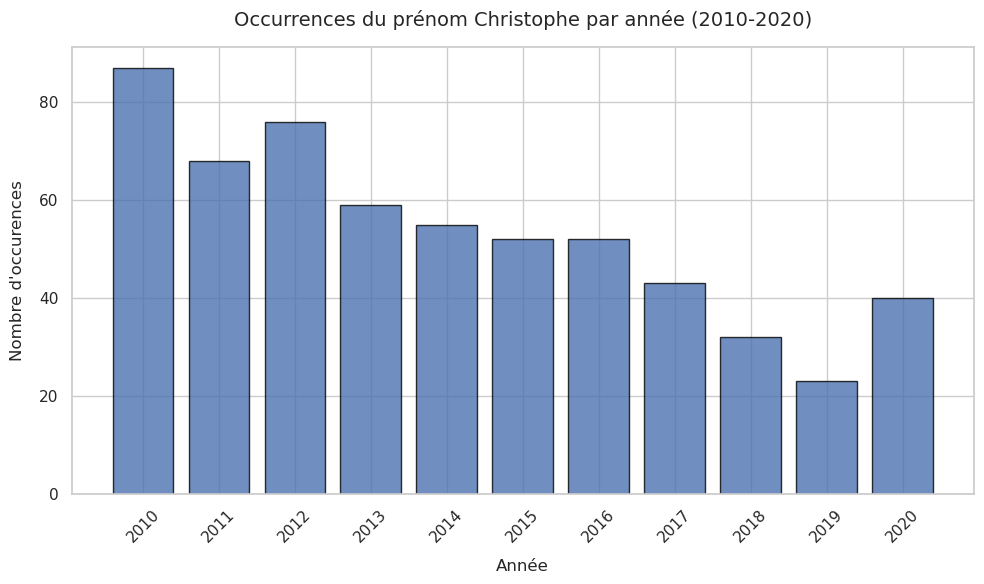

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for a cleaner, more appealing look
sns.set_theme(style="whitegrid")

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Data
years = df_prenom_annee["annais"].to_list()         # Extracts years as a list
counts = df_prenom_annee["nombre_total"].to_list()  # Extracts counts as a list

# Bar plot with custom colors and transparency for better visuals
ax.bar(years, 
       counts, 
       color="#4C72B0", 
       edgecolor="black", 
       alpha=0.8)

# Set labels and title with padding for readability
ax.set_xlabel("Année", fontsize=12, labelpad=10)
ax.set_ylabel("Nombre d'occurences", fontsize=12, labelpad=10)
ax.set_title(f"Occurrences du prénom {prenom} par année ({annee_debut}-{annee_fin})", fontsize=14, pad=15)

# Rotate x-axis labels, improve spacing, and format grid
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()  # Adjust layout for tight fit

# Display the plot
plt.show()

In [39]:
# Export des résultats

import s3fs

fs = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://'+'minio-simple.lab.groupe-genes.fr'},
    key = os.environ["AWS_ACCESS_KEY_ID"], 
    secret = os.environ["AWS_SECRET_ACCESS_KEY"], 
    token = os.environ["AWS_SESSION_TOKEN"])

destination = f"s3://{username}/diffusion/INSEE/output.csv"

with fs.open(destination, mode='wb') as f:
    top10f2021.write_csv(f)

/tmp/ipykernel_1035/4171598918.py:14: UserWarning: Polars found a filename. Ensure you pass a path to the file instead of a python file object when possible for best performance.
  top10f2021.write_csv(f)
